Since the dataset contains multiple payment methods (PayPal, Venmo, Credit Card, etc.), the target variable was engineered by converting the Payment_Method column into a binary classification variable. Customers using PayPal were labeled as 1, while all other payment methods were labeled as 0. This transformation enables a clear comparison between PayPal and non-PayPal users and supports the use of binary classification models.

# Import Libraries

In [209]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [104]:
df = pd.read_csv("data/shopping_trends_updated.csv")

# Rename the column 'Purchase Amount (USD)' to 'Purchase_Amount' and replace spaces with underscores
df.columns = df.columns.str.replace('Purchase Amount (USD)', 'Purchase_Amount')
df.columns = df.columns.str.replace(' ', '_')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer_ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item_Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase_Amount         3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review_Rating           3900 non-null   float64
 11  Subscription_Status     3900 non-null   object 
 12  Shipping_Type           3900 non-null   object 
 13  Discount_Applied        3900 non-null   object 
 14  Promo_Code_Used         3900 non-null   

# Data Cleaning

In [106]:
# removing cash as its not an online payment method
df = df[df["Payment_Method"] != "Cash"]
print(df.head())

   Customer_ID  Age Gender Item_Purchased  Category  Purchase_Amount  \
0            1   55   Male         Blouse  Clothing               53   
2            3   50   Male          Jeans  Clothing               73   
3            4   21   Male        Sandals  Footwear               90   
4            5   45   Male         Blouse  Clothing               49   
5            6   46   Male       Sneakers  Footwear               20   

        Location Size      Color  Season  Review_Rating Subscription_Status  \
0       Kentucky    L       Gray  Winter            3.1                 Yes   
2  Massachusetts    S     Maroon  Spring            3.1                 Yes   
3   Rhode Island    M     Maroon  Spring            3.5                 Yes   
4         Oregon    M  Turquoise  Spring            2.7                 Yes   
5        Wyoming    M      White  Summer            2.9                 Yes   

   Shipping_Type Discount_Applied Promo_Code_Used  Previous_Purchases  \
0        Express   

In [124]:
# grouping shipping types to 2 groups - express and standard
def group_ship(shipping):
    if shipping in ["Standard", "Store Pickup", "2-Day Shipping"]:
        return "Standard"
    else:
        return "Express"

def group_season(season):
    if season in ["Spring", "Winter"]:
        return "Winter_Spring"
    else:
        return "Summer_Fall"

def group_freq(freq):
    if freq in ["Bi-Weekly", "Fortnightly", "Monthly","Weekly"]:
        return "More_Frequent"
    if freq in ["Every 3 Months", "Quarterly"]:
        return "Medium_Frequent"
    else:
        return "Less_Frequent"

In [126]:
df.loc[:, "shipping_group"] = df["Shipping_Type"].apply(group_ship)
print(df["shipping_group"])
df["shipping_group"].value_counts()

df.loc[:, "season_group"] = df["Season"].apply(group_season)
print(df["season_group"])
df["season_group"].value_counts()

df.loc[:, "freq_group"] = df["Frequency_of_Purchases"].apply(group_freq)
print(df["freq_group"])
df["freq_group"].value_counts()

0        Express
2        Express
3        Express
4        Express
5       Standard
          ...   
3895    Standard
3896    Standard
3897    Standard
3898     Express
3899    Standard
Name: shipping_group, Length: 3230, dtype: object
0       Winter_Spring
2       Winter_Spring
3       Winter_Spring
4       Winter_Spring
5         Summer_Fall
            ...      
3895      Summer_Fall
3896    Winter_Spring
3897    Winter_Spring
3898      Summer_Fall
3899    Winter_Spring
Name: season_group, Length: 3230, dtype: object
0         More_Frequent
2         More_Frequent
3         More_Frequent
4         Less_Frequent
5         More_Frequent
             ...       
3895      More_Frequent
3896      More_Frequent
3897    Medium_Frequent
3898      More_Frequent
3899    Medium_Frequent
Name: freq_group, Length: 3230, dtype: object


freq_group
More_Frequent      1791
Medium_Frequent     949
Less_Frequent       490
Name: count, dtype: int64

In [231]:
# Create target variable with 1 for PaypalUser
df.loc[:, 'paypal_user'] = np.where(
    df['Payment_Method'] == 'PayPal', 1, 0
)

# Feature selection
X = df[['Season', 'shipping_group', 'Age', 'freq_group','Category','Subscription_Status',
        'Gender','Discount_Applied','Promo_Code_Used','Previous_Purchases'
       ]]
y = df['paypal_user']

# One-hot encoding for categorical variables
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}\n")

Training samples: 2584
Testing samples: 646



# Train Multiple Models

In [233]:
print("Step 3: Training multiple classification models...")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} model trained successfully.")

print()

Step 3: Training multiple classification models...
Logistic Regression model trained successfully.
Random Forest model trained successfully.



# Cross validation

In [235]:
print("Step 4: Performing cross-validation on models...")

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} Cross-Validated Accuracy: {cv_scores.mean():.3f}")

print("Cross-validation completed.\n")

Step 4: Performing cross-validation on models...
Logistic Regression Cross-Validated Accuracy: 0.790
Random Forest Cross-Validated Accuracy: 0.771
Cross-validation completed.



# Grid Search for Hyperparameter Tuning

In [237]:
print("Step 5: Performing Grid Search for hyperparameter tuning...")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Grid Search completed.")
print("Best Hyperparameters Found:", grid_search.best_params_)
print()


Step 5: Performing Grid Search for hyperparameter tuning...
Grid Search completed.
Best Hyperparameters Found: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}



# Model Evaluation

In [241]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred,zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print()


Test Accuracy: 0.791

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       511
           1       0.00      0.00      0.00       135

    accuracy                           0.79       646
   macro avg       0.40      0.50      0.44       646
weighted avg       0.63      0.79      0.70       646

Confusion Matrix:
[[511   0]
 [135   0]]



# Model Interpretation

In [243]:
print("Step 7: Interpreting model results using feature importance...")

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top contributing features:")
print(feature_importance.head())

print("\nModel interpretation completed.")


Step 7: Interpreting model results using feature importance...
Top contributing features:
                    Feature  Importance
0                       Age    0.311835
1        Previous_Purchases    0.309090
5   shipping_group_Standard    0.047837
7  freq_group_More_Frequent    0.036212
8         Category_Clothing    0.035285

Model interpretation completed.


# Final Summary Print

In [177]:
print("Modeling pipeline completed successfully.")
print("Multiple models trained, validated, tuned, evaluated, and interpreted.")

Modeling pipeline completed successfully.
Multiple models trained, validated, tuned, evaluated, and interpreted.


# Feature Importance Bar Chart

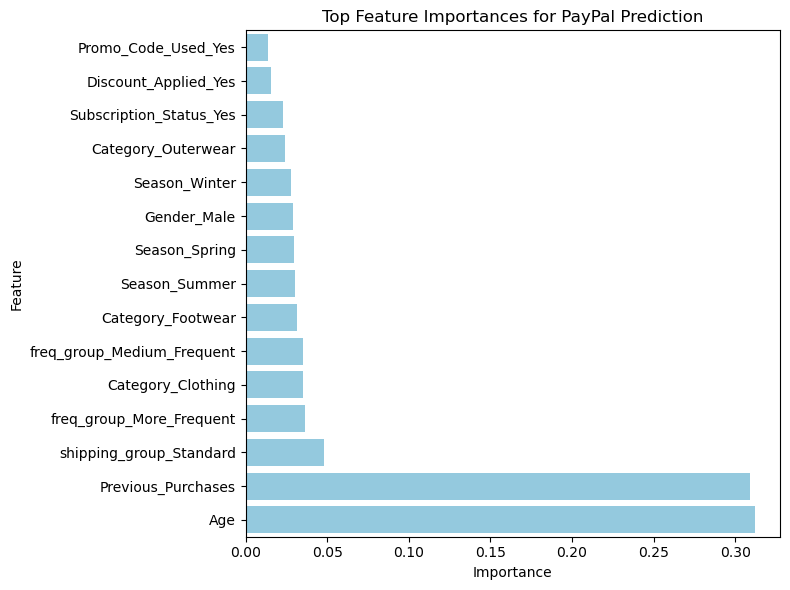

In [249]:
feature_importance_sorted = feature_importance.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_sorted, color='skyblue')
plt.title('Top Feature Importances for PayPal Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("./images/feature_importance.png")
plt.show()

# Confusion Matrix Heatmap

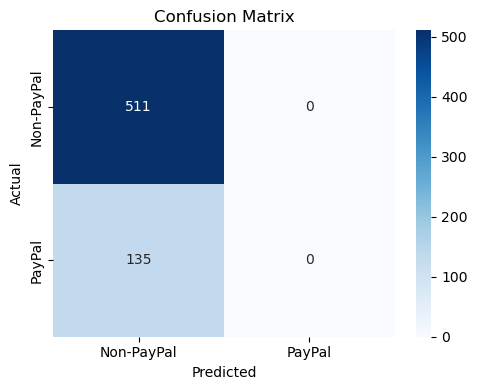

In [251]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-PayPal','PayPal'], yticklabels=['Non-PayPal','PayPal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("./images/confusion_matrix.png")  # Saves the plot
plt.show()